In [1]:
import numpy as np
import soundfile as sf
from scipy import signal
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from pathlib import Path
import os
from tqdm import tqdm
import imageio
import warnings

warnings.filterwarnings('ignore')

# ============================================================================
# PART 1: Load Audio File
# ============================================================================

# audio_path = 'pitch_rise.wav'
# audio_path = 'c3 16 441.wav'
# audio_path = '230212_2022_high_inthe_sky.wav'
audio_path = '240703_1912_soybean_machine.wav'
audio_data, sr = sf.read(audio_path)

# Keep stereo if available, otherwise duplicate mono to stereo
if len(audio_data.shape) == 1:
    # Mono: duplicate to create stereo
    audio_data = np.column_stack([audio_data, audio_data])
    print("Audio was mono, duplicated to stereo")
else:
    # Stereo: keep as is
    print(f"Stereo audio loaded: shape {audio_data.shape}")

# Extract left and right channels
audio_left = audio_data[:, 0]
audio_right = audio_data[:, 1]

print(f"Audio loaded: {len(audio_left)} samples at {sr} Hz")
print(f"Duration: {len(audio_left) / sr:.2f} seconds")
print(f"Channels: Left and Right (stereo)")

# ============================================================================
# PART 2: Compute FFTs for Both Channels
# ============================================================================

fps = 24
num_frames = int(np.ceil(len(audio_left) / sr * fps))
print(f"Number of frames: {num_frames}")

# Frequency range parameters
f_low = 30  # Hz
f_high = 12000  # Hz
f_mid = 120  # Hz (boundary between low and high frequency ranges)

# FFT window sizes
n_samples_high = 12000  # For 120 Hz - 12 kHz
n_samples_low = 12000   # For 30 Hz - 120 Hz

# Precompute frequency arrays for FFTs
freqs_high = rfftfreq(n_samples_high, 1/sr)
freqs_low = rfftfreq(n_samples_low, 1/sr)

# Find indices for frequency ranges
idx_high_start = np.searchsorted(freqs_high, f_mid)
idx_high_end = np.searchsorted(freqs_high, f_high)

idx_low_start = np.searchsorted(freqs_low, f_low)
idx_low_end = np.searchsorted(freqs_low, f_mid)

print(f"High freq range (120 Hz - 12 kHz): {idx_high_end - idx_high_start} bins")
print(f"Low freq range (30 Hz - 120 Hz): {idx_low_end - idx_low_start} bins")

# Total frequency bins
n_freq_bins = (idx_high_end - idx_high_start) + (idx_low_end - idx_low_start)
print(f"Total frequency bins: {n_freq_bins}")

def compute_frame_fft(frame_idx, audio_channel):
    """Compute FFT for a single frame of a given audio channel."""
    # Sample position for this frame
    sample_start = int(frame_idx * sr / fps)
    
    # Extract audio segments
    # High frequency: 120 Hz - 12 kHz using 12k samples
    seg_high_start = sample_start
    seg_high_end = min(sample_start + n_samples_high, len(audio_channel))
    seg_high = audio_channel[seg_high_start:seg_high_end]
    if len(seg_high) < n_samples_high:
        seg_high = np.pad(seg_high, (0, n_samples_high - len(seg_high)), mode='constant')
    
    # Low frequency: 30 Hz - 120 Hz using 24k samples
    seg_low_start = sample_start
    seg_low_end = min(sample_start + n_samples_low, len(audio_channel))
    seg_low = audio_channel[seg_low_start:seg_low_end]
    if len(seg_low) < n_samples_low:
        seg_low = np.pad(seg_low, (0, n_samples_low - len(seg_low)), mode='constant')
    
    # Apply Hann window
    seg_high *= np.hanning(len(seg_high))
    seg_low *= np.hanning(len(seg_low))
    
    # Compute FFTs
    fft_high = np.abs(rfft(seg_high))
    fft_low = np.abs(rfft(seg_low))
    
    # Extract frequency ranges (already sorted by frequency)
    coeffs_high = fft_high[idx_high_start:idx_high_end]
    coeffs_low = fft_low[idx_low_start:idx_low_end]
    
    # Concatenate: low frequencies first, then high
    frame_coeffs = np.concatenate([coeffs_low, coeffs_high])
    return frame_coeffs

# Compute FFTs for both channels sequentially with progress bar
print("Computing FFTs for LEFT channel...")
fft_results_left = []
for frame_idx in tqdm(range(num_frames), desc="FFT computation (left)"):
    fft_results_left.append(compute_frame_fft(frame_idx, audio_left))

print("Computing FFTs for RIGHT channel...")
fft_results_right = []
for frame_idx in tqdm(range(num_frames), desc="FFT computation (right)"):
    fft_results_right.append(compute_frame_fft(frame_idx, audio_right))

fft_array_left = np.array(fft_results_left, dtype=np.float32)
fft_array_right = np.array(fft_results_right, dtype=np.float32)
print(f"FFT array shapes - Left: {fft_array_left.shape}, Right: {fft_array_right.shape}")

# ============================================================================
# FREQUENCY-DEPENDENT RESCALING (after FFT, before outlier clipping)
# ============================================================================
# Linear rescaling as a function of frequency:
# At 30 Hz (low): multiply by 0.7
# At 12 kHz (high): multiply by 2.0
# Coefficients are rescaled linearly based on their position in the frequency array

print("\nApplying frequency-dependent linear rescaling...")

# Compute the frequency axis corresponding to the concatenated FFT coefficients
# Low frequencies first (30 Hz - 120 Hz), then high (120 Hz - 12 kHz)
freqs_low_used = freqs_low[idx_low_start:idx_low_end]
freqs_high_used = freqs_high[idx_high_start:idx_high_end]
freqs_all = np.concatenate([freqs_low_used, freqs_high_used])

print(f"  Frequency range: {freqs_all[0]:.1f} Hz to {freqs_all[-1]:.1f} Hz")
print(f"  Total bins: {len(freqs_all)}")

# Create linear rescaling function
# At f_low (30 Hz): scale = 0.7
# At f_high (12 kHz): scale = 2.0
scale_low = 0.7
scale_high = 2.0
f_low_freq = float(freqs_all[0])
f_high_freq = float(freqs_all[-1])

# Linear interpolation: scale(f) = scale_low + (f - f_low) / (f_high - f_low) * (scale_high - scale_low)
scale_factors = scale_low + (freqs_all - f_low_freq) / (f_high_freq - f_low_freq) * (scale_high - scale_low)

print(f"  Scale factors: {scale_factors[0]:.3f} at {f_low_freq:.1f} Hz to {scale_factors[-1]:.3f} at {f_high_freq:.1f} Hz")

# Apply frequency-dependent rescaling to both channels
fft_array_left = fft_array_left * scale_factors[None, :]  # Broadcast scale_factors to all frames
fft_array_right = fft_array_right * scale_factors[None, :]

print(f"  Applied frequency-dependent rescaling to both channels")
print(f"  Left channel range after rescaling: {fft_array_left.min():.6e} to {fft_array_left.max():.6e}")
print(f"  Right channel range after rescaling: {fft_array_right.min():.6e} to {fft_array_right.max():.6e}")

# IMPORTANT: Save the raw FFT arrays BEFORE any normalization
# These are the true, unnormalized audio spectra (with frequency-dependent rescaling applied)
fft_array_left_raw = fft_array_left.copy()
fft_array_right_raw = fft_array_right.copy()
print(f"\nRaw FFT arrays saved for diagnostic analysis:")
print(f"  Left - Range: {fft_array_left_raw.min():.6e} to {fft_array_left_raw.max():.6e}")
print(f"  Right - Range: {fft_array_right_raw.min():.6e} to {fft_array_right_raw.max():.6e}")
print(f"  These WILL be normalized using outlier-aware clipping in diagnostic cells below")

Stereo audio loaded: shape (20030010, 2)
Audio loaded: 20030010 samples at 44100 Hz
Duration: 454.20 seconds
Channels: Left and Right (stereo)
Number of frames: 10901
High freq range (120 Hz - 12 kHz): 3233 bins
Low freq range (30 Hz - 120 Hz): 24 bins
Total frequency bins: 3257
Computing FFTs for LEFT channel...


FFT computation (left): 100%|██████████| 10901/10901 [00:03<00:00, 3188.23it/s]


Computing FFTs for RIGHT channel...


FFT computation (right): 100%|██████████| 10901/10901 [00:03<00:00, 3215.56it/s]


FFT array shapes - Left: (10901, 3257), Right: (10901, 3257)

Applying frequency-dependent linear rescaling...
  Frequency range: 33.1 Hz to 11998.9 Hz
  Total bins: 3257
  Scale factors: 0.700 at 33.1 Hz to 2.000 at 11998.9 Hz
  Applied frequency-dependent rescaling to both channels
  Left channel range after rescaling: 2.209321e-06 to 1.431424e+03
  Right channel range after rescaling: 6.377721e-06 to 1.442365e+03

Raw FFT arrays saved for diagnostic analysis:
  Left - Range: 2.209321e-06 to 1.431424e+03
  Right - Range: 6.377721e-06 to 1.442365e+03
  These WILL be normalized using outlier-aware clipping in diagnostic cells below


Inspecting frame 10 of 10900
FFT data shape: (10901, 3257)
Frame coefficients min/max: 0.000107 / 0.816221


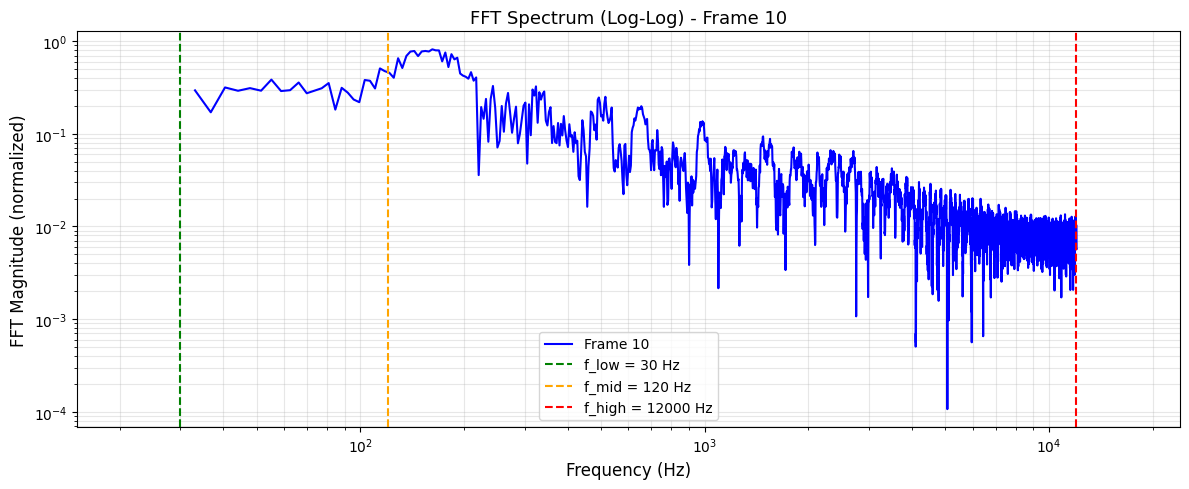


Frequency range included in FFT: 33.1 Hz to 11998.9 Hz
Total frequency bins: 3257
Saved plot to fft_inspection.png


In [12]:
# ============================================================================
# DEBUG: Inspect FFT Results (before PART 3)
# ============================================================================

# Reconstruct freqs_used locally for inspection
freqs_used_low = freqs_low[idx_low_start:idx_low_end]
freqs_used_high = freqs_high[idx_high_start:idx_high_end]
freqs_used = np.concatenate([freqs_used_low, freqs_used_high])

# Pick a frame index to inspect (0 to num_frames-1)
frame_to_inspect = 10  # Change this to inspect different frames

print(f"Inspecting frame {frame_to_inspect} of {num_frames-1}")
print(f"FFT data shape: {fft_array_left.shape}")
print(f"Frame coefficients min/max: {fft_array_left[frame_to_inspect].min():.6f} / {fft_array_left[frame_to_inspect].max():.6f}")

# Plot the FFT with log frequency scale
fig, ax = plt.subplots(figsize=(12, 5))

# Use the concatenated frequencies (low then high)
ax.loglog(freqs_used, fft_array_left[frame_to_inspect], 'b-', linewidth=1.5, label=f'Frame {frame_to_inspect}')

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('FFT Magnitude (normalized)', fontsize=12)
ax.set_title(f'FFT Spectrum (Log-Log) - Frame {frame_to_inspect}', fontsize=13)
ax.grid(True, which='both', alpha=0.3)

# Mark the frequency boundaries
ax.axvline(f_low, color='green', linestyle='--', linewidth=1.5, label=f'f_low = {f_low} Hz')
ax.axvline(f_mid, color='orange', linestyle='--', linewidth=1.5, label=f'f_mid = {f_mid} Hz')
ax.axvline(f_high, color='red', linestyle='--', linewidth=1.5, label=f'f_high = {f_high} Hz')

ax.legend(fontsize=10)
ax.set_xlim([f_low * 0.5, f_high * 2])

plt.tight_layout()
# plt.savefig('fft_inspection.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nFrequency range included in FFT: {freqs_used[0]:.1f} Hz to {freqs_used[-1]:.1f} Hz")
print(f"Total frequency bins: {len(freqs_used)}")
print(f"Saved plot to fft_inspection.png")


DIAGNOSTIC: FFT Coefficient Analysis Across All Frames
NOTE: Analyzing RAW (unnormalized) FFT coefficients


FFT Coefficient Maxima per Frame:
  Min: 2.911999e-01
  Max: 1.431424e+03
  Mean: 8.497845e+00
  Median: 8.383307e+00
  Std: 1.603289e+01

Percentiles of Frame Maxima:
  1st percentile:  9.664878e-01
  5th percentile:  3.023792e+00
  25th percentile: 6.854808e+00
  50th percentile: 8.383307e+00 (median)
  75th percentile: 9.964401e+00
  95th percentile: 1.266476e+01
  99th percentile: 1.429185e+01

Outlier Detection (IQR method):
  Q1: 6.854808e+00, Q3: 1.290270e+01, IQR: 6.047887e+00
  Low outlier threshold: -2.217023e+00
  High outlier threshold: 2.197453e+01
  Low outliers (frames): []
  High outliers (frames): [0 1 2 3]


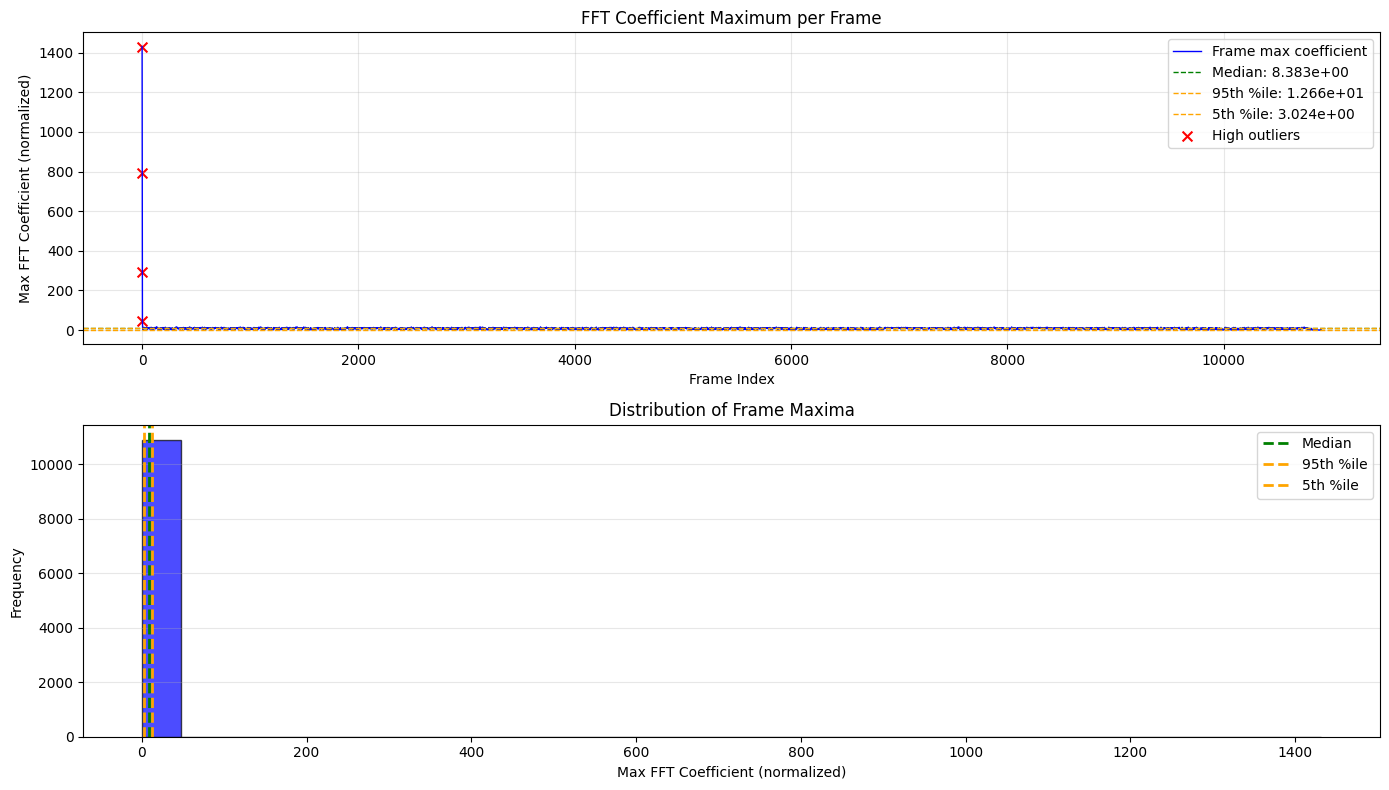


Saved analysis to fft_coefficient_analysis.png

⚠️  Found 4 outlier frames
  These may be from beginning/end of file or other artifacts


In [13]:
# ============================================================================
# DIAGNOSTIC: Analyze FFT coefficient dynamics across all frames
# ============================================================================

print("=" * 70)
print("DIAGNOSTIC: FFT Coefficient Analysis Across All Frames")
print("=" * 70)

# Use the RAW FFT coefficients (before normalization) for this analysis
# This shows the true dynamic range of the audio without per-frame normalization artifacts
print("NOTE: Analyzing RAW (unnormalized) FFT coefficients")
print()

# For each frame, find the maximum coefficient
frame_maxes = np.max(fft_array_left_raw, axis=1)  # (num_frames,)

print(f"\nFFT Coefficient Maxima per Frame:")
print(f"  Min: {frame_maxes.min():.6e}")
print(f"  Max: {frame_maxes.max():.6e}")
print(f"  Mean: {frame_maxes.mean():.6e}")
print(f"  Median: {np.median(frame_maxes):.6e}")
print(f"  Std: {frame_maxes.std():.6e}")

# Calculate percentiles to identify outliers
p1, p5, p25, p50, p75, p95, p99 = np.percentile(frame_maxes, [1, 5, 25, 50, 75, 95, 99])
print(f"\nPercentiles of Frame Maxima:")
print(f"  1st percentile:  {p1:.6e}")
print(f"  5th percentile:  {p5:.6e}")
print(f"  25th percentile: {p25:.6e}")
print(f"  50th percentile: {p50:.6e} (median)")
print(f"  75th percentile: {p75:.6e}")
print(f"  95th percentile: {p95:.6e}")
print(f"  99th percentile: {p99:.6e}")

# Find outliers (frames with unusually high or low max coefficients)
q1, q3 = np.percentile(frame_maxes, [25, 96])
iqr = q3 - q1
outlier_low_threshold = q1 - 1.5 * iqr
outlier_high_threshold = q3 + 1.5 * iqr

outliers_low = np.where(frame_maxes < outlier_low_threshold)[0]
outliers_high = np.where(frame_maxes > outlier_high_threshold)[0]

print(f"\nOutlier Detection (IQR method):")
print(f"  Q1: {q1:.6e}, Q3: {q3:.6e}, IQR: {iqr:.6e}")
print(f"  Low outlier threshold: {outlier_low_threshold:.6e}")
print(f"  High outlier threshold: {outlier_high_threshold:.6e}")
print(f"  Low outliers (frames): {outliers_low}")
print(f"  High outliers (frames): {outliers_high}")

# Plot frame maxima over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Frame maxima over time
ax = axes[0]
ax.plot(frame_maxes, 'b-', linewidth=1, label='Frame max coefficient')
ax.axhline(p50, color='g', linestyle='--', linewidth=1, label=f'Median: {p50:.3e}')
ax.axhline(p95, color='orange', linestyle='--', linewidth=1, label=f'95th %ile: {p95:.3e}')
ax.axhline(p5, color='orange', linestyle='--', linewidth=1, label=f'5th %ile: {p5:.3e}')
if len(outliers_low) > 0:
    ax.scatter(outliers_low, frame_maxes[outliers_low], color='red', s=50, marker='x', label='Low outliers')
if len(outliers_high) > 0:
    ax.scatter(outliers_high, frame_maxes[outliers_high], color='red', s=50, marker='x', label='High outliers')
ax.set_xlabel('Frame Index')
ax.set_ylabel('Max FFT Coefficient (normalized)')
ax.set_title('FFT Coefficient Maximum per Frame')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 2: Histogram of frame maxima
ax = axes[1]
ax.hist(frame_maxes, bins=30, color='blue', alpha=0.7, edgecolor='black')
ax.axvline(p50, color='g', linestyle='--', linewidth=2, label=f'Median')
ax.axvline(p95, color='orange', linestyle='--', linewidth=2, label=f'95th %ile')
ax.axvline(p5, color='orange', linestyle='--', linewidth=2, label=f'5th %ile')
ax.set_xlabel('Max FFT Coefficient (normalized)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Frame Maxima')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
# plt.savefig('fft_coefficient_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nSaved analysis to fft_coefficient_analysis.png")

# Summary
if len(outliers_low) > 0 or len(outliers_high) > 0:
    print(f"\n⚠️  Found {len(outliers_low) + len(outliers_high)} outlier frames")
    print(f"  These may be from beginning/end of file or other artifacts")
else:
    print(f"\n✓ No statistical outliers detected")
    print(f"  Coefficient dynamics appear stable across the file")


In [15]:
# ============================================================================
# STRATEGY: Outlier Clipping - Process Both Channels Independently
# ============================================================================

def process_channel(fft_array_raw_ch, channel_name="Channel"):
    """
    Process a single channel: detect outliers, clip them, and normalize to [0,1].
    Returns the processed FFT array and clipping statistics.
    """
    print(f"\n{'='*70}")
    print(f"Processing {channel_name}")
    print(f"{'='*70}")
    
    # Step 1: Compute frame maxima from RAW FFT
    frame_maxes_raw = np.max(fft_array_raw_ch, axis=1)

    print(f"\nStep 1: Frame maxima statistics (RAW FFT):")
    print(f"  Min: {frame_maxes_raw.min():.6e}")
    print(f"  Max: {frame_maxes_raw.max():.6e}")
    print(f"  Mean: {frame_maxes_raw.mean():.6e}")
    print(f"  Median: {np.median(frame_maxes_raw):.6e}")

    # Step 2: Identify outliers using IQR method
    q1, q3 = np.percentile(frame_maxes_raw, [25, 96])
    iqr = q3 - q1
    outlier_high_threshold = q3 + 1.5 * iqr
    outliers_high_clipping = np.where(frame_maxes_raw > outlier_high_threshold)[0]

    print(f"\nStep 2: Outlier detection (IQR method):")
    print(f"  Q1: {q1:.6e}, Q3: {q3:.6e}, IQR: {iqr:.6e}")
    print(f"  High outlier threshold: {outlier_high_threshold:.6e}")
    print(f"  Outlier frames: {outliers_high_clipping} ({len(outliers_high_clipping)} total)")

    # Step 3: Compute average of non-outlier frame maxima
    non_outlier_mask_clipping = np.ones(num_frames, dtype=bool)
    non_outlier_mask_clipping[outliers_high_clipping] = False
    non_outlier_frame_maxes_clipping = frame_maxes_raw[non_outlier_mask_clipping]
    average_non_outlier_max = np.mean(non_outlier_frame_maxes_clipping)

    print(f"\nStep 3: Non-outlier average calculation:")
    print(f"  Non-outlier frames: {len(non_outlier_frame_maxes_clipping)} out of {num_frames}")
    print(f"  Non-outlier min: {non_outlier_frame_maxes_clipping.min():.6e}")
    print(f"  Non-outlier max: {non_outlier_frame_maxes_clipping.max():.6e}")
    print(f"  Non-outlier average: {average_non_outlier_max:.6e}")

    # Step 4: Clip outliers to the average value
    print(f"\nStep 4: Clipping outliers to average value...")
    fft_array_clipped = fft_array_raw_ch.copy()

    # For each outlier frame, scale its coefficients so that its maximum equals the non-outlier average
    for frame_idx in outliers_high_clipping:
        frame_max = np.max(fft_array_clipped[frame_idx])
        if frame_max > 0:
            scale_factor = average_non_outlier_max / frame_max
            fft_array_clipped[frame_idx] *= scale_factor

    # Verify the clipping
    frame_maxes_clipped = np.max(fft_array_clipped, axis=1)

    print(f"\nVerification after clipping:")
    print(f"  Clipped frame maxima - Min: {frame_maxes_clipped.min():.6e}")
    print(f"  Clipped frame maxima - Max: {frame_maxes_clipped.max():.6e}")
    print(f"  Clipped frame maxima - Mean: {frame_maxes_clipped.mean():.6e}")
    print(f"  Clipped frame maxima - Median: {np.median(frame_maxes_clipped):.6e}")

    # Show specific outlier values after clipping
    print(f"\nOutlier frames after clipping (max coefficient):")
    print(f"{'Frame':>8} {'Before':>20} {'After':>20} {'Target':>20}")
    print(f"{'-'*70}")
    for frame_idx in outliers_high_clipping[:6]:
        print(f"{frame_idx:8d} {frame_maxes_raw[frame_idx]:20.6e} {frame_maxes_clipped[frame_idx]:20.6e} {average_non_outlier_max:20.6e}")

    # Step 5: Renormalize clipped FFTs to [0,1]
    print("\nStep 5: Renormalize clipped FFT coefficients to [0,1]")
    coef_min = float(fft_array_clipped.min())
    coef_max = float(fft_array_clipped.max())
    print(f"  coefficient min: {coef_min:.6e}, max: {coef_max:.6e}")
    if coef_max - coef_min > 0:
        fft_array_normalized = (fft_array_clipped - coef_min) / (coef_max - coef_min)
    else:
        fft_array_normalized = fft_array_clipped.copy()

    print(f"  After normalization - min: {fft_array_normalized.min():.6e}, max: {fft_array_normalized.max():.6e}, mean: {fft_array_normalized.mean():.6e}")

    print(f"\n✓ {channel_name} - Outlier clipping and normalization complete")
    
    return fft_array_normalized

# Process both channels
print("=" * 70)
print("STRATEGY: Outlier Clipping & Normalization (Both Channels)")
print("=" * 70)

fft_array_left = process_channel(fft_array_left_raw, "LEFT CHANNEL")
fft_array_right = process_channel(fft_array_right_raw, "RIGHT CHANNEL")

STRATEGY: Outlier Clipping & Normalization (Both Channels)

Processing LEFT CHANNEL

Step 1: Frame maxima statistics (RAW FFT):
  Min: 2.911999e-01
  Max: 1.431424e+03
  Mean: 8.497845e+00
  Median: 8.383307e+00

Step 2: Outlier detection (IQR method):
  Q1: 6.854808e+00, Q3: 1.290270e+01, IQR: 6.047887e+00
  High outlier threshold: 2.197453e+01
  Outlier frames: [0 1 2 3] (4 total)

Step 3: Non-outlier average calculation:
  Non-outlier frames: 10897 out of 10901
  Non-outlier min: 2.911999e-01
  Non-outlier max: 1.621089e+01
  Non-outlier average: 8.265786e+00

Step 4: Clipping outliers to average value...

Verification after clipping:
  Clipped frame maxima - Min: 2.911999e-01
  Clipped frame maxima - Max: 1.621089e+01
  Clipped frame maxima - Mean: 8.265786e+00
  Clipped frame maxima - Median: 8.381300e+00

Outlier frames after clipping (max coefficient):
   Frame               Before                After               Target
--------------------------------------------------------

In [5]:
# ============================================================================
# STRATEGY: Contrast Rescaling & Dynamic Range Compression (Both Channels)
# ============================================================================

def apply_contrast_and_compression(fft_array_norm, channel_name="Channel", C=2.0, compression_threshold=0.7, compression_factor=0.5):
    """
    Apply contrast rescaling and dynamic range compression to an FFT array.
    Returns the processed array.
    """
    print(f"\n{'='*70}")
    print(f"Applying contrast rescaling and compression to {channel_name}")
    print(f"{'='*70}")
    
    # === Step 1: Apply contrast rescaling function ===
    # Rescale using sigmoid-like function: rescaled_x = x / (1 + exp(-C*(x - 0.5)))
    # Input fft_array is already in [0,1] from previous cell
    print(f"\nStep 1: Apply contrast rescaling function with C={C}")
    exp_arg = -C * (fft_array_norm + 0.5)
    exp_arg_clipped = np.clip(exp_arg, -50.0, 50.0)
    denom = 1.0 + np.exp(exp_arg_clipped)
    fft_array_rescaled = fft_array_norm / denom

    print(f"  After rescale (pre-normalize) - min: {fft_array_rescaled.min():.6e}, max: {fft_array_rescaled.max():.6e}, mean: {fft_array_rescaled.mean():.6e}")

    # === Step 2: Renormalize rescaled coefficients back to [0,1] ===
    print("\nStep 2: Renormalize rescaled FFT coefficients to [0,1]")
    res_min = float(fft_array_rescaled.min())
    res_max = float(fft_array_rescaled.max())
    print(f"  rescaled min: {res_min:.6e}, max: {res_max:.6e}")
    if res_max - res_min > 0:
        fft_array_rescaled = (fft_array_rescaled - res_min) / (res_max - res_min)
    else:
        fft_array_rescaled = fft_array_rescaled.copy()

    print(f"  After rescale-and-normalize - min: {fft_array_rescaled.min():.6e}, max: {fft_array_rescaled.max():.6e}, mean: {fft_array_rescaled.mean():.6e}")

    # === Step 3: Apply dynamic range compression ===
    print("\nStep 3: Apply dynamic range compression")
    
    # Compute global max across all frames for threshold reference
    global_max_coef = float(fft_array_rescaled.max())
    threshold_value = compression_threshold * global_max_coef

    print(f"  Global max coefficient: {global_max_coef:.6e}")
    print(f"  Compression threshold: {compression_threshold} * max = {threshold_value:.6e}")
    print(f"  Compression factor: {compression_factor}")

    # Apply compression: coefficients above threshold are reduced
    # C_compressed = C - compression_factor * (C - threshold) for C > threshold
    fft_array_compressed = fft_array_rescaled.copy()

    # Find coefficients above threshold
    above_threshold = fft_array_compressed > threshold_value

    # Apply compression formula: reduce by compression_factor * (C - threshold)
    fft_array_compressed[above_threshold] -= compression_factor * (fft_array_compressed[above_threshold] - threshold_value)

    print(f"  Coefficients above threshold: {np.sum(above_threshold)} out of {fft_array_compressed.size}")
    print(f"  Compressed coefficients - min: {fft_array_compressed.min():.6e}, max: {fft_array_compressed.max():.6e}")

    # === Step 4: Renormalize compressed coefficients back to [0,1] ===
    print("\nStep 4: Renormalize compressed FFT coefficients to [0,1]")
    comp_min = float(fft_array_compressed.min())
    comp_max = float(fft_array_compressed.max())
    print(f"  Compressed min: {comp_min:.6e}, max: {comp_max:.6e}")
    if comp_max - comp_min > 0:
        fft_array_compressed = (fft_array_compressed - comp_min) / (comp_max - comp_min)
    else:
        fft_array_compressed = fft_array_compressed.copy()

    print(f"  After compression-and-normalize - min: {fft_array_compressed.min():.6e}, max: {fft_array_compressed.max():.6e}, mean: {fft_array_compressed.mean():.6e}")

    print(f"\n✓ {channel_name} - Contrast rescaling and compression complete")
    
    return fft_array_compressed

# Apply contrast rescaling and compression to both channels
print("=" * 70)
print("STRATEGY: Contrast Rescaling & Compression (Both Channels)")
print("=" * 70)

C = 20.0
compression_threshold = 0.4
compression_factor = 0.8

fft_array_left = apply_contrast_and_compression(fft_array_left, "LEFT CHANNEL", C=C, compression_threshold=compression_threshold, compression_factor=compression_factor)
fft_array_right = apply_contrast_and_compression(fft_array_right, "RIGHT CHANNEL", C=C, compression_threshold=compression_threshold, compression_factor=compression_factor)

STRATEGY: Contrast Rescaling & Compression (Both Channels)

Applying contrast rescaling and compression to LEFT CHANNEL

Step 1: Apply contrast rescaling function with C=20.0
  After rescale (pre-normalize) - min: 0.000000e+00, max: 1.000000e+00, mean: 1.471829e-02

Step 2: Renormalize rescaled FFT coefficients to [0,1]
  rescaled min: 0.000000e+00, max: 1.000000e+00
  After rescale-and-normalize - min: 0.000000e+00, max: 1.000000e+00, mean: 1.471829e-02

Step 3: Apply dynamic range compression
  Global max coefficient: 1.000000e+00
  Compression threshold: 0.4 * max = 4.000000e-01
  Compression factor: 0.8
  Coefficients above threshold: 47041 out of 35504557
  Compressed coefficients - min: 0.000000e+00, max: 5.200000e-01

Step 4: Renormalize compressed FFT coefficients to [0,1]
  Compressed min: 0.000000e+00, max: 5.200000e-01
  After compression-and-normalize - min: 0.000000e+00, max: 1.000000e+00, mean: 2.811792e-02

✓ LEFT CHANNEL - Contrast rescaling and compression complete

Ap

In [16]:
# ============================================================================
# DIAGNOSTIC: Verify Outlier Clipping - Before/After Comparison
# ============================================================================

print("=" * 70)
print("DIAGNOSTIC: FFT Coefficient Analysis - Before/After Outlier Clipping")
print("=" * 70)

print(f"\n{'BEFORE Outlier Clipping (raw FFT):':^70}")
print(f"  Min: {frame_maxes_raw.min():.6e}")
print(f"  Max: {frame_maxes_raw.max():.6e} ← Peak outlier")
print(f"  Mean: {frame_maxes_raw.mean():.6e}")
print(f"  Median: {np.median(frame_maxes_raw):.6e}")
print(f"  Std: {frame_maxes_raw.std():.6e}")

print(f"\n{'AFTER Outlier Clipping (clipped FFT):':^70}")
print(f"  Min: {frame_maxes_clipped.min():.6e}")
print(f"  Max: {frame_maxes_clipped.max():.6e} ← Clipped to average")
print(f"  Mean: {frame_maxes_clipped.mean():.6e}")
print(f"  Median: {np.median(frame_maxes_clipped):.6e}")
print(f"  Std: {frame_maxes_clipped.std():.6e}")

# Analyze non-outlier frames (should be unchanged)
non_outlier_before = frame_maxes_raw[non_outlier_mask_clipping]
non_outlier_after = frame_maxes_clipped[non_outlier_mask_clipping]
print(f"\n{'NON-OUTLIER frames (should be unchanged):':^70}")
print(f"  Before - Min: {non_outlier_before.min():.6e}, Max: {non_outlier_before.max():.6e}")
print(f"  After  - Min: {non_outlier_after.min():.6e}, Max: {non_outlier_after.max():.6e}")
print(f"  Difference: {np.max(np.abs(non_outlier_before - non_outlier_after)):.6e}")

# Show outlier frame maxes before/after
print(f"\n{'Outlier frames - Max coefficient values:':^70}")
print(f"{'Frame':>8} {'Before Clipping':>20} {'After Clipping':>20} {'Target':>20}")
print(f"{'-'*70}")
for frame_idx in outliers_high_clipping[:6]:
    print(f"{frame_idx:8d} {frame_maxes_raw[frame_idx]:20.6e} {frame_maxes_clipped[frame_idx]:20.6e} {average_non_outlier_max:20.6e}")

# Plot before/after comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Frame maxima over time (BEFORE)
ax = axes[0, 0]
ax.plot(frame_maxes_raw, 'b-', linewidth=1, label='All frames')
ax.scatter(outliers_high_clipping, frame_maxes_raw[outliers_high_clipping], color='red', s=50, marker='x', label='Outliers')
ax.axhline(average_non_outlier_max, color='orange', linestyle='--', linewidth=1, label=f'Target = {average_non_outlier_max:.3e}')
ax.set_xlabel('Frame Index')
ax.set_ylabel('Max FFT Coefficient')
ax.set_title('BEFORE: Raw FFT Coefficients (Log Scale)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 2: Frame maxima over time (AFTER)
ax = axes[0, 1]
ax.plot(frame_maxes_clipped, 'g-', linewidth=1, label='All frames (clipped)')
ax.scatter(outliers_high_clipping, frame_maxes_clipped[outliers_high_clipping], color='red', s=50, marker='x', label='Previously outliers')
ax.axhline(average_non_outlier_max, color='orange', linestyle='--', linewidth=1, label=f'Target = {average_non_outlier_max:.3e}')
ax.set_xlabel('Frame Index')
ax.set_ylabel('Max FFT Coefficient')
ax.set_title('AFTER: Clipped FFT Coefficients (Log Scale)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 3: Histogram BEFORE
ax = axes[1, 0]
ax.hist(frame_maxes_raw, bins=30, color='blue', alpha=0.7, edgecolor='black', label='All frames')
ax.axvline(np.median(frame_maxes_raw), color='g', linestyle='--', linewidth=2, label=f'Median: {np.median(frame_maxes_raw):.2e}')
ax.axvline(average_non_outlier_max, color='orange', linestyle='--', linewidth=2, label=f'Target: {average_non_outlier_max:.2e}')
ax.set_xlabel('Max FFT Coefficient')
ax.set_ylabel('Frequency')
ax.set_title('BEFORE: Distribution of Frame Maxima')
ax.set_xscale('log')
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

# Plot 4: Histogram AFTER
ax = axes[1, 1]
ax.hist(frame_maxes_clipped, bins=30, color='green', alpha=0.7, edgecolor='black', label='All frames (clipped)')
ax.axvline(np.median(frame_maxes_clipped), color='g', linestyle='--', linewidth=2, label=f'Median: {np.median(frame_maxes_clipped):.2e}')
ax.axvline(average_non_outlier_max, color='orange', linestyle='--', linewidth=2, label=f'Target: {average_non_outlier_max:.2e}')
ax.set_xlabel('Max FFT Coefficient')
ax.set_ylabel('Frequency')
ax.set_title('AFTER: Distribution of Clipped Frame Maxima')
ax.set_xscale('log')
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

plt.tight_layout()
# plt.savefig('fft_before_after_clipping.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved before/after comparison to fft_before_after_clipping.png")

# Summary
print(f"\n{'SUMMARY':^70}")
print(f"  Non-outlier frames unchanged: ✓")
print(f"  Outlier frames clipped to: {average_non_outlier_max:.3e}")
print(f"  All frame maxes now in uniform range: {frame_maxes_clipped.min():.3e} to {frame_maxes_clipped.max():.3e}")


DIAGNOSTIC: FFT Coefficient Analysis - Before/After Outlier Clipping

                  BEFORE Outlier Clipping (raw FFT):                  


NameError: name 'frame_maxes_raw' is not defined

In [7]:
# ============================================================================
# PRECOMPUTE: Spatial mapping (pixel units) and separable cosine bases
# ============================================================================
# Image pixel dims (HD)
width = 1920
height = 1080

# Pixel coordinate arrays (units: pixels)
x_pixels = np.arange(width)   # 0 .. width-1
y_pixels = np.arange(height)  # 0 .. height-1

# Wavenumber bounds in pixels^-1 (keep your original choice)
k_l = 1.0 / (height)   # one period over image height
k_u = 1.0 / 8.0      # high spatial frequency (1 per 5 pixels)

# freqs_used was constructed in the FFT inspection cell; map those freqs -> k_spatial
# Use a log mapping between k_l and k_u to respect perceptual scaling
# k_spatial = np.logspace(np.log(k_l), np.log(k_u), len(freqs_used)).astype(np.float32)
k_spatial = np.linspace(k_l, k_u, len(freqs_used)).astype(np.float32)

# Precompute separable cosine bases in pixel units:
# cos_k_x shape: (n_freq, width), cos_k_y shape: (n_freq, height)
cos_k_x = np.cos(2.0 * np.pi * k_spatial[:, None] * x_pixels[None, :]).astype(np.float32)
cos_k_y = np.cos(2.0 * np.pi * k_spatial[:, None] * y_pixels[None, :]).astype(np.float32)

# Provide simple aliases used elsewhere in the notebook
x = x_pixels
y = y_pixels

print(f"Precomputed cosine bases: cos_k_x {cos_k_x.shape}, cos_k_y {cos_k_y.shape}")
print(f"k_spatial range: {k_spatial.min():.6e} .. {k_spatial.max():.6e} (pixels^-1)")


Precomputed cosine bases: cos_k_x (3257, 1920), cos_k_y (3257, 1080)
k_spatial range: 9.259259e-04 .. 1.250000e-01 (pixels^-1)


DIAGNOSTIC: Single Frame Test (Frame 100) - Both Channels

Frame 100 FFT Statistics:

LEFT CHANNEL:
  Shape: (3257,)
  Min: 2.871365e-04
  Max: 7.551191e-01
  Mean: 1.101264e-02
  Std: 3.940084e-02

RIGHT CHANNEL:
  Shape: (3257,)
  Min: 2.403215e-05
  Max: 7.115452e-01
  Mean: 1.080345e-02
  Std: 4.163619e-02

Spatial Field Statistics:

LEFT CHANNEL field:
  Shape: (1080, 1920)
  Min: -5.671839
  Max: 35.868157
  Mean: 0.007919

RIGHT CHANNEL field (reflected about Y):
  Shape: (1080, 1920)
  Min: -6.807385
  Max: 35.186829
  Mean: 0.006781

Intensity (Magnitude |F|) Statistics:

LEFT CHANNEL:
  Min: 0.000000
  Max: 35.868156
  Mean: 1.691920

RIGHT CHANNEL (reflected):
  Min: 0.000001
  Max: 35.186829
  Mean: 1.758176


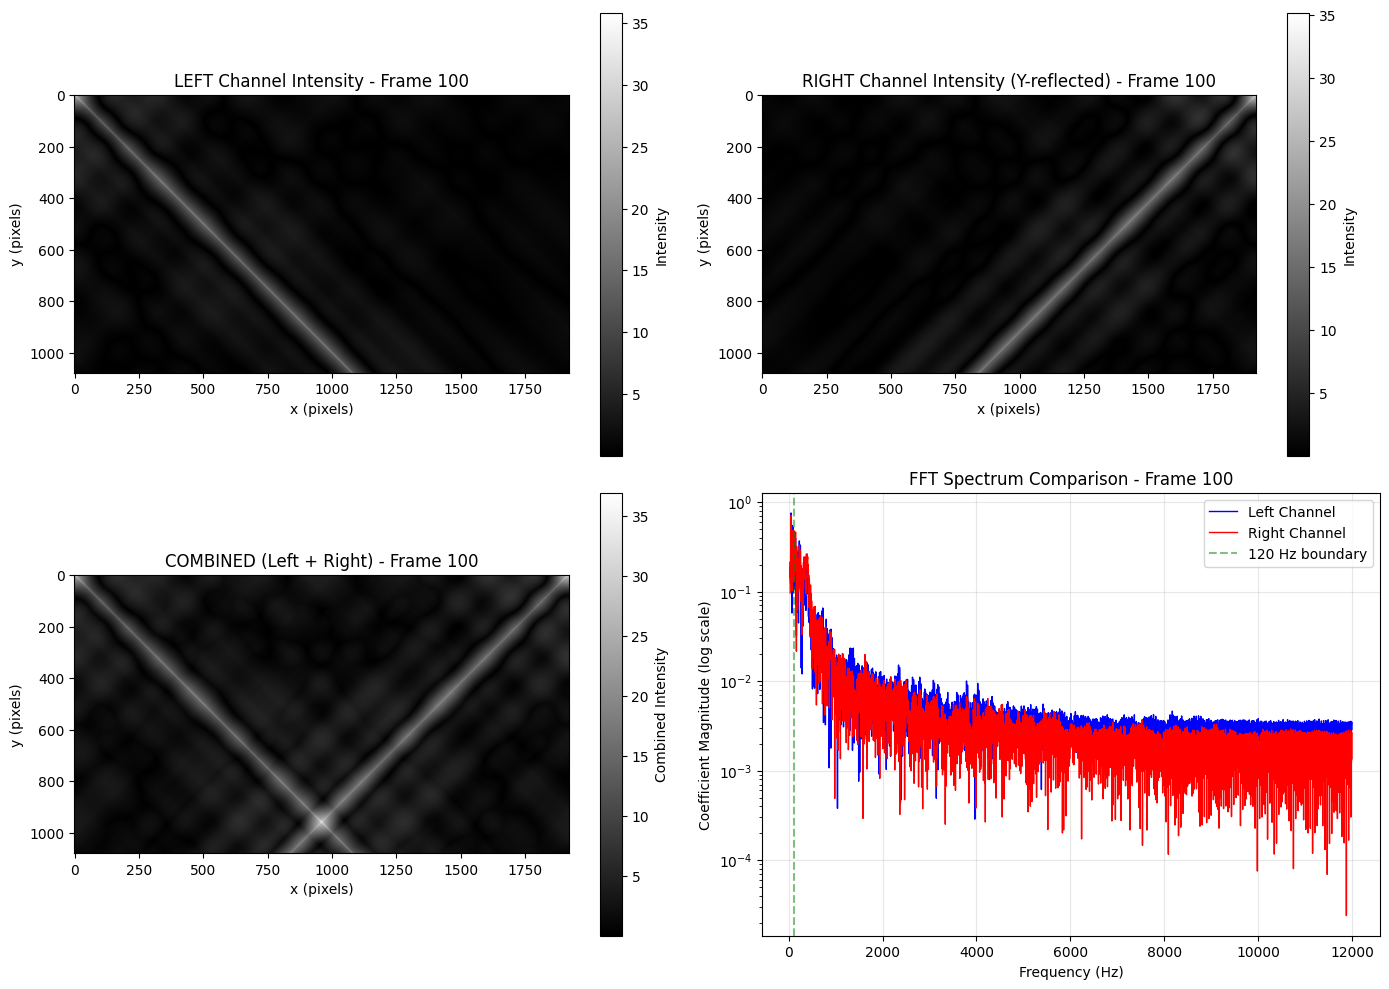


Saved diagnostic visualization to single_frame_diagnostic_stereo.png


In [8]:
# ============================================================================
# DIAGNOSTIC: Test single frame to preview intensity patterns before full run
# ============================================================================

# Pick a frame to inspect (0 to num_frames-1)
test_frame_idx = 100

print("=" * 70)
print(f"DIAGNOSTIC: Single Frame Test (Frame {test_frame_idx}) - Both Channels")
print("=" * 70)

# Get FFT coefficients for this frame from both channels
coeffs_left = fft_array_left[test_frame_idx]
coeffs_right = fft_array_right[test_frame_idx]

print(f"\nFrame {test_frame_idx} FFT Statistics:")
print(f"\nLEFT CHANNEL:")
print(f"  Shape: {coeffs_left.shape}")
print(f"  Min: {coeffs_left.min():.6e}")
print(f"  Max: {coeffs_left.max():.6e}")
print(f"  Mean: {coeffs_left.mean():.6e}")
print(f"  Std: {coeffs_left.std():.6e}")

print(f"\nRIGHT CHANNEL:")
print(f"  Shape: {coeffs_right.shape}")
print(f"  Min: {coeffs_right.min():.6e}")
print(f"  Max: {coeffs_right.max():.6e}")
print(f"  Mean: {coeffs_right.mean():.6e}")
print(f"  Std: {coeffs_right.std():.6e}")

# Compute 2D field using separable basis for LEFT channel
Y_weighted_left = (coeffs_left[:, None] * cos_k_y)  # (n_freq, height)
field_left = Y_weighted_left.T.dot(cos_k_x)        # (height, width)

# Compute 2D field for RIGHT channel (reflected about Y-axis)
# x_pixels_reflected = width - 1 - x_pixels (flips the x-coordinate)
cos_k_x_reflected = np.cos(2.0 * np.pi * k_spatial[:, None] * (width - 1 - x_pixels)[None, :]).astype(np.float32)
Y_weighted_right = (coeffs_right[:, None] * cos_k_y)  # (n_freq, height)
field_right = Y_weighted_right.T.dot(cos_k_x_reflected)  # (height, width) - reflected

print(f"\nSpatial Field Statistics:")
print(f"\nLEFT CHANNEL field:")
print(f"  Shape: {field_left.shape}")
print(f"  Min: {field_left.min():.6f}")
print(f"  Max: {field_left.max():.6f}")
print(f"  Mean: {field_left.mean():.6f}")

print(f"\nRIGHT CHANNEL field (reflected about Y):")
print(f"  Shape: {field_right.shape}")
print(f"  Min: {field_right.min():.6f}")
print(f"  Max: {field_right.max():.6f}")
print(f"  Mean: {field_right.mean():.6f}")

# Compute magnitude for both channels
intensity_left = np.abs(field_left).astype(np.float32)
intensity_right = np.abs(field_right).astype(np.float32)

print(f"\nIntensity (Magnitude |F|) Statistics:")
print(f"\nLEFT CHANNEL:")
print(f"  Min: {intensity_left.min():.6f}")
print(f"  Max: {intensity_left.max():.6f}")
print(f"  Mean: {intensity_left.mean():.6f}")

print(f"\nRIGHT CHANNEL (reflected):")
print(f"  Min: {intensity_right.min():.6f}")
print(f"  Max: {intensity_right.max():.6f}")
print(f"  Mean: {intensity_right.mean():.6f}")

# Visualize both channels
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Left channel intensity
ax = axes[0, 0]
im = ax.imshow(intensity_left, cmap='gray', origin='upper')
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
ax.set_title(f'LEFT Channel Intensity - Frame {test_frame_idx}')
plt.colorbar(im, ax=ax, label='Intensity')

# Plot 2: Right channel intensity (reflected)
ax = axes[0, 1]
im = ax.imshow(intensity_right, cmap='gray', origin='upper')
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
ax.set_title(f'RIGHT Channel Intensity (Y-reflected) - Frame {test_frame_idx}')
plt.colorbar(im, ax=ax, label='Intensity')

# Plot 3: Combined (left + right)
intensity_combined = intensity_left + intensity_right
ax = axes[1, 0]
im = ax.imshow(intensity_combined, cmap='gray', origin='upper')
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
ax.set_title(f'COMBINED (Left + Right) - Frame {test_frame_idx}')
plt.colorbar(im, ax=ax, label='Combined Intensity')

# Plot 4: FFT spectra comparison
ax = axes[1, 1]
ax.semilogy(freqs_used, coeffs_left, 'b-', linewidth=1, label='Left Channel')
ax.semilogy(freqs_used, coeffs_right, 'r-', linewidth=1, label='Right Channel')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Coefficient Magnitude (log scale)')
ax.set_title(f'FFT Spectrum Comparison - Frame {test_frame_idx}')
ax.grid(True, alpha=0.3)
ax.axvline(f_mid, color='g', linestyle='--', alpha=0.5, label='120 Hz boundary')
ax.legend()

plt.tight_layout()
# plt.savefig('single_frame_diagnostic_stereo.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\nSaved diagnostic visualization to single_frame_diagnostic_stereo.png")

In [9]:
# ============================================================================
# PART 3: Compute 2D spatial magnitude patterns for both channels (sequential loop)
# ============================================================================

import os
import subprocess
from pathlib import Path

# Create temp directory for frame storage
temp_dir = Path('temp_frames')
temp_dir.mkdir(exist_ok=True)

# Use compression to save disk space
use_compressed = True

print("Computing spatial magnitude patterns for all frames (both channels)...")
print(f"Saving frames to {temp_dir}")

# Precompute reflected x basis for right channel (reflected about Y-axis)
# x_pixels_reflected = width - 1 - x_pixels
cos_k_x_reflected = np.cos(2.0 * np.pi * k_spatial[:, None] * (width - 1 - x_pixels)[None, :]).astype(np.float32)

# Compute all magnitudes and find per-frame min/max for normalization
mins = []
maxs = []

for frame_idx in tqdm(range(num_frames), desc="Computing magnitude patterns"):
    # Get FFT coefficients for this frame from both channels
    coeffs_left = fft_array_left[frame_idx]
    coeffs_right = fft_array_right[frame_idx]
    
    # Compute 2D field for LEFT channel using separable basis and matrix multiply (memory-efficient)
    # Field(x,y) = Σ_k coeffs[k] * cos(2π k_spatial[k] x) * cos(2π k_spatial[k] y)
    Y_weighted_left = (coeffs_left[:, None] * cos_k_y)  # (n_freq, height)
    field_left = Y_weighted_left.T.dot(cos_k_x)        # (height, width)
    
    # Compute 2D field for RIGHT channel with Y-reflection (reflected x basis)
    Y_weighted_right = (coeffs_right[:, None] * cos_k_y)  # (n_freq, height)
    field_right = Y_weighted_right.T.dot(cos_k_x_reflected)  # (height, width) - reflected
    
    # Combine both channels
    field_combined = field_left + field_right
    
    # Compute magnitude (|F(x,y)|) of combined field
    magnitude = np.abs(field_combined).astype(np.float32)
    
    # Track per-frame min/max
    frame_min = magnitude.min()
    frame_max = magnitude.max()
    mins.append(frame_min)
    maxs.append(frame_max)
    
    # Save magnitude to temp file (compressed or uncompressed)
    output_path = temp_dir / f"frame_{frame_idx:06d}"
    if use_compressed:
        np.savez_compressed(f"{output_path}.npz", intensity=magnitude)
    else:
        # keep key name 'intensity' for downstream compatibility
        np.save(f"{output_path}.npy", magnitude)

print(f"\nMagnitude patterns computed for {num_frames} frames (stereo combined)")
print(f"Per-frame magnitude ranges:")
print(f"  Min of all frame-mins: {min(mins):.6e}")
print(f"  Max of all frame-maxs: {max(maxs):.6e}")
print(f"  Mean frame-max: {np.mean(maxs):.6e}")
print(f"Temp frames stored in {temp_dir}")

# Compute global min/max for GLOBAL normalization (with outlier-suppressed FFT)
# This preserves audio dynamics while avoiding outlier-driven dark frames
global_min = float(np.min(mins))
global_max = float(np.max(maxs))
print(f"\nGLOBAL normalization parameters:")
print(f"  Global min: {global_min:.6e}")
print(f"  Global max: {global_max:.6e}")
print(f"  Dynamic range: {global_max - global_min:.6e}")
print(f"\nNOTE: Using GLOBAL normalization in PART 5")
print(f"      Left channel (normal) + Right channel (Y-reflected)")
print(f"      Both processed independently with outlier clipping and compression")

Computing spatial magnitude patterns for all frames (both channels)...
Saving frames to temp_frames


Computing magnitude patterns: 100%|██████████| 10901/10901 [1:27:05<00:00,  2.09it/s]


Magnitude patterns computed for 10901 frames (stereo combined)
Per-frame magnitude ranges:
  Min of all frame-mins: 8.387735e-13
  Max of all frame-maxs: 1.673172e+02
  Mean frame-max: 9.399907e+01
Temp frames stored in temp_frames

GLOBAL normalization parameters:
  Global min: 8.387735e-13
  Global max: 1.673172e+02
  Dynamic range: 1.673172e+02

NOTE: Using GLOBAL normalization in PART 5
      Left channel (normal) + Right channel (Y-reflected)
      Both processed independently with outlier clipping and compression


In [10]:
# PART 5: Generate and Save Video with Audio (stream frames from disk to save memory)
# ============================================================================

output_video_path = 'audio_visualizer.mp4'
temp_video_path = 'audio_visualizer_no_audio.mp4'

print(f"Generating video: {output_video_path}")
print(f"Video spec: {width}x{height} @ {fps} fps, {num_frames} frames")

# Create video writer (use yuv420p pixelformat for wide compatibility)
writer = imageio.get_writer(temp_video_path, fps=fps, codec='libx264', pixelformat='yuv420p', quality=8)

# Read each raw intensity file, apply colormap (blue->white->red), write frame, then delete
print("Writing frames to video (reading from temp files, GLOBAL normalization + colormap)...")
print(f"Using global_min={global_min:.6e}, global_max={global_max:.6e}")

from matplotlib import cm
# cmap = cm.get_cmap('RdBu_r')  # blue -> white -> red
cmap = cm.get_cmap('twilight')  # blue -> white -> red

# Ensure file list is sorted by frame index
frame_files = sorted(Path('temp_frames').glob('frame_*.npy'))
if use_compressed:
    frame_files = sorted(Path('temp_frames').glob('frame_*.npz'))
if len(frame_files) != num_frames:
    print(f"Warning: expected {num_frames} temp frames but found {len(frame_files)}")

for p in tqdm(frame_files, total=len(frame_files)):

    # Load .npz files with a context manager so underlying file handles are closed
    # (on Windows an open handle prevents deletion, causing WinError 32)
    if use_compressed:
        # np.load returns an NpzFile which keeps the file open until closed.
        # Using `with` ensures the file is closed immediately after reading.
        with np.load(p) as data:
            # copy the array so it's not a view backed by the open file
            intensity = data['intensity'].copy()
    else:
        # .npy load returns an array and does not keep an open handle
        intensity = np.load(p)

    # Normalize to [0,1]
    if global_max - global_min > 0:
        norm = (intensity - global_min) / (global_max - global_min)
    else:
        norm = intensity.copy()
    norm = np.clip(norm, 0.0, 1.0)

    # Apply colormap -> RGBA floats in [0,1], convert to uint8 RGB
    rgba = cmap(norm)
    rgb = (rgba[..., :3] * 255).astype(np.uint8)

    # Append RGB frame to video
    writer.append_data(rgb)

    # remove references and close variables so file handles are freed promptly
    try:
        del intensity
    except Exception:
        pass

    # delete the temp file to free disk space
    try:
        os.remove(p)
    except Exception as e:
        print(f"Could not remove temp file {p}: {e}")

writer.close()
print("Video written (without audio)")

# Remove temp directory if empty
try:
    temp_dir = Path('temp_frames')
    if temp_dir.exists() and not any(temp_dir.iterdir()):
        temp_dir.rmdir()
        print(f"Removed temporary directory: {temp_dir}")
except Exception as e:
    print(f"Could not remove temp dir: {e}")

# Merge audio with video using ffmpeg
print("Merging audio with video...")

# Robust ffmpeg detection: check PATH, common env vars, imageio_ffmpeg, and common Windows locations
import shutil
import os
ffmpeg_path = shutil.which('ffmpeg') or shutil.which('ffmpeg.exe')

if not ffmpeg_path:
    # Check environment variables that sometimes hold the ffmpeg binary path
    ffmpeg_path = os.environ.get('FFMPEG_PATH') or os.environ.get('FFMPEG_BINARY')

if not ffmpeg_path:
    # Try imageio-ffmpeg helper (if installed)
    try:
        import imageio_ffmpeg as _iioff
        ffmpeg_path = _iioff.get_ffmpeg_exe()
    except Exception:
        ffmpeg_path = ffmpeg_path

if not ffmpeg_path:
    # Check a few common Windows install locations
    common_windows_paths = [
        r"C:\Program Files\ffmpeg\bin\ffmpeg.exe",
        r"C:\Program Files (x86)\ffmpeg\bin\ffmpeg.exe",
        r"C:\ffmpeg\bin\ffmpeg.exe",
    ]
    for p in common_windows_paths:
        if os.path.exists(p):
            ffmpeg_path = p
            break

if not ffmpeg_path:
    print("\n⚠️  ffmpeg not found on system!")
    print("I attempted the following checks:")
    print(" - shutil.which('ffmpeg') and shutil.which('ffmpeg.exe')")
    print(" - environment vars 'FFMPEG_PATH' and 'FFMPEG_BINARY'")
    print(" - imageio_ffmpeg.get_ffmpeg_exe() (if imageio-ffmpeg installed)")
    print(" - common Windows install paths: C:\\Program Files\\ffmpeg\\bin\\ffmpeg.exe, etc.")
    print("\nIf ffmpeg is installed but not found, either:")
    print("  1) Add the directory containing ffmpeg.exe to your PATH environment variable and restart your Python session")
    print("  2) Or set the environment variable FFMPEG_PATH to the full path of ffmpeg.exe before running this cell")
    print("     e.g. in PowerShell: $env:FFMPEG_PATH = 'C:\\ffmpeg\\bin\\ffmpeg.exe'")
    print("  3) Or install imageio-ffmpeg in your Python environment: pip install imageio-ffmpeg")
    print("\nBecause ffmpeg was not found, the audio will NOT be merged. Temporary video (no audio) is kept:")
    print(f"Output: {temp_video_path}")
else:
    # Merge using the discovered ffmpeg binary
    ffmpeg_cmd = [
        ffmpeg_path,
        '-i', temp_video_path,
        '-i', audio_path,
        '-c:v', 'copy',
        '-c:a', 'aac',
        '-map', '0:v:0',
        '-map', '1:a:0',
        '-shortest',
        '-y',
        output_video_path
    ]

    result = subprocess.run(ffmpeg_cmd, capture_output=True, text=True)
    if result.returncode == 0:
        print(f"✓ Video with audio saved: {output_video_path}")
        # Clean up temporary file
        try:
            os.remove(temp_video_path)
        except Exception:
            pass
    else:
        print("Error merging audio:")
        print(result.stderr)
        print("Keeping temporary video file:", temp_video_path)

print(f"\nVisualization complete!")
print(f"Output: {output_video_path}")


Generating video: audio_visualizer.mp4
Video spec: 1920x1080 @ 24 fps, 10901 frames
Writing frames to video (reading from temp files, GLOBAL normalization + colormap)...
Using global_min=8.387735e-13, global_max=1.673172e+02


100%|██████████| 10901/10901 [23:49<00:00,  7.63it/s]


Video written (without audio)
Removed temporary directory: temp_frames
Merging audio with video...
✓ Video with audio saved: audio_visualizer.mp4

Visualization complete!
Output: audio_visualizer.mp4


## Advanced Options & Analysis

This section provides utilities for exploring the visualization and applying non-linear scaling.

I have an idea for an audio visualizer. I have a test audio file called pitch_rise.wav we can use. It is a 16 bit 44.1k audio file. The video output I want to be grayscale 1080p HD 24 frames per second. We will add in a color degree of freedom later. I want to import the file and take the fft of chunks of the audio file as a function of time to display the frequency spectrum according to some mapping to pixels I will define over the audio file as the sound plays. 

Can you write me some code that does the following? 

(1) import the audio file. 

(2) compute and store the ffts in an array. Since the video will be 24 fps, divide the audio file into a total number of segments equal to the audio file length in seconds times 24. Each segment should then represent a time step in the audio file. For each time step, we will compute the fft twice. First compute the fft for the following 12k samples starting from the given time step and store the coefficients for frequencies from 120 Hz to 12 kHz in an array. Then compute the fft for the same time step again but for the following 24k samples, and append the coefficients for frequencies from 30 Hz to 120 Hz in the same array. Therefore after the ffts have been computed for every time step we should have an array of dimension (L, 12.e3 - 30) where L is the total number of frames in our video and the second dimension is total number of frequencies included in each frame. 

(3) map the frequencies for each time step to pixels in an image. The first mapping I want to try is a map to 2D spatial frequencies. To keep things simple, the spatial frequencies are symmetric in X and Y (a given spatial frequency in X is the same in Y). If our resolution is HD 1080p, then we have a grid of 1920 by 1080 pixels. Let our lowest frequency (30 Hz) map to a spatial frequency of k_l = 2*pi*(1 / 1080 pixels) (that is, one period of the lowest frequency should fit in the height of the pixel grid). Let the highest frequency map to k_u = 2*pi*(1/ 6 pixels). The mapping needs to account for the logarithmic perception of sound frequencies, so we want the scaling between lowest and highest frequencies to be logarithmic. If we think of our signal as a fourier series, then for each frame of video we originally have an associated fourier series of the form F(t) = sum_{f=30}^{f=12.e3}(C_f * cos(2pi f t)) where C_f are the coefficients computed from the FFts; the mapping should take this series in time to one in space of the form $F(x) = sum_{k = k_l}^{k = k_u}(C_k \cos(2 pi k x)). Since X and Y are symmetric the series will be the same for y. Now, in order to observe interesting interference effects, I want to take the modulus squared of this sum as the final step of the map. Then after the mapping the code should make a new array of dimension (L, 1920, 1080) where L is the total number of frames of video, and the second two dimensions are the pixel index in width (X) and height (Y). 

(4) Renormalize the values for each pixel in our array to grayscale. We may want to renormalize to a non-linear scaling to emphasize 'louder' values more than values close to 0, but for now let's assume a linear mapping between the pixel values and grayscale, with the option to change it later.

(5) Generate and save the video, with the imported audio file attached.

It may be computationally expensive the perform the mapping in step (3), so we should play any tricks we can to parallelize and speed up the operations.